# USD/MXN Exchange Rate during 2016 US Election Night - Under Construction

During the night of the 2016 US election night, we saw Donald Trump won the presidency while most polling agency predicted Hillary Clinton would be victorious. This came as a suprise to the most people. In this project I would like to how the financial market reacted during the election night.

## Background:
During the campaign Donald Trump repeatedly mentioned building a wall between the US and Mexico boarder, putting high import tariff on imported goods from Mexico and renegotiate or abandon NAFTA. All such action are seen as negatives for the Mexican economy whose biggest export market is the US. It is no suprise that in the event of a trump victory, the Mexican Peso will depreciate against other currencies.

In this project I will run a realtime analysis on Trumps victory chance and see how fast the financial market reacted as the result came out from each state.

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug  2 16:32:27 2017

@author: AlexH
"""

#Priors 1: state, number


#Updates & Results: state, time, number

#Step 1, get all data (use just website time info for now)

#Step 2, rolling regression

#Step 3, find error margin at each stage

#Step 4, compare with financial data
    

import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
import random

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime
import matplotlib.dates as mdates
import pylab


C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Getting the Data

The data is collected from the internet, polling data is from Fivethrityeight 'prior-538.csv' and the election realtime data is recorded by watching BBC/CNN election live broadcast 'results.csv'.

In [261]:
#%%
#Reading in data


# with open('data/prior_538.csv', newline='') as csvfile:
#     data = csv.reader(csvfile, delimiter=',')
#     prior=list(data)
prior = pd.read_csv('data/prior_538.csv')

prior = pd.DataFrame(prior)
prior.columns = ['State', 'poll_hc', 'poll_dt', 'poll_gj']
prior.State=[name.replace('-',' ') for name in prior.State]

#with open('call-AP.csv', newline='') as csvfile:
#    data = csv.reader(csvfile, delimiter=',')
#    call=list(data)
#
#call = pd.DataFrame(call)
#call.columns = ['State', 'result', 'time']

with open('data/results CNN-2.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    result=list(data)

result = pd.DataFrame(result)
result.columns = ['State', 'result', 'time', 'trump', 'clinton', 'EV', 'intermediate','rprpc']
result.State=[name.lower() for name in result.State]


#join the table by state
jointb = prior.join(result.set_index('State'), on='State')
#order by time




for i in range(len(jointb)):
    try:
        jointb.time.iloc[i]=datetime.strptime(jointb.time.iloc[i], '%Y-%m-%d %H:%M')
    except:
        jointb.time.iloc[i]=datetime.strptime(jointb.time.iloc[i], '%Y-%m-%d %I:%M%p')

jointb = jointb.sort_values(by='time').reset_index(drop=True)
jointb.index = np.arange(0,len(jointb))
jointb[[ 'EV','result', 'trump', 'clinton', 'poll_hc', 'poll_dt', 'poll_gj','rprpc']]=jointb[[ 'EV','result', 'trump', 'clinton','poll_hc', 'poll_dt', 'poll_gj','rprpc' ]].apply(pd.to_numeric)
#jointb.EV.fillna(0,inplace =True)


C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Linear Regression and Monte Carlos Simulation



In [297]:

#storing result
columns = ['time', 'state','low', 'ave', 'high','clinton']
index= jointb.index
pred=pd.DataFrame(index=index, columns=columns)

parameters_trump = np.empty((len(jointb),2))
stderr_trump = np.empty((len(jointb),2))
parameters_clinton = np.empty((len(jointb),2))
stderr_clinton = np.empty((len(jointb),2))

#number of simulation for (a,b) and (error)
sim_num = 200
for i in range(14,len(jointb)-4):
    
    #Trump regression
    #fit linear regression
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')
    #intermediate = intermediate[intermediate.rprpc>20]

    X_dt=intermediate['poll_dt']
    if len(X_dt)<4:
        continue
    Y_dt=intermediate['trump']
    #X_dt=sm.add_constant(X_dt)
    model_dt = sm.RLM(Y_dt.values, X_dt.values,weights=intermediate['rprpc']).fit()
    
    parameters_trump[i,:]=model_dt.params
    stderr_trump[i,:]=model_dt.bse
    
    #extract parameters
    params_dt = np.random.multivariate_normal(model_dt.params, RegressionResults.cov_params(model_dt), sim_num**2)
#    slope_dt = np.random.normal(model_dt.params[1], model_dt.bse[1], sim_num)
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    #X_hc=sm.add_constant(X_hc)
    model_hc = sm.WLS(Y_hc.values, X_hc.values,weights=intermediate['rprpc']).fit()
    
    parameters_clinton[i,:]=model_hc.params
    stderr_clinton[i,:]=model_hc.bse
    params_hc = np.random.multivariate_normal(model_hc.params, RegressionResults.cov_params(model_hc), sim_num**2)

    
    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')
    
#    result = np.zeros([sim_num, len(remain)])
    
#    for j in range(0, sim_num):
        
        #trump
    #result_dt = np.dot(params_dt,sm.add_constant(np.array(remain['poll_dt'])).T)
    result_dt = np.dot(params_dt,np.matrix(remain['poll_dt']))
    #result_dt = np.random.normal(result_dt, np.std(model_dt.resid))
    err_dev = np.std(model_dt.resid)*(np.random.chisquare(len(model_dt.resid)-1)*1./(len(model_dt.resid)-1))**0.5
    result_dt = np.random.normal(result_dt, err_dev)
        
        
        #clinton
    #result_hc = np.dot(params_hc, sm.add_constant(np.array(remain['poll_hc'])).T) 
    result_hc = np.dot(params_hc, np.matrix(remain['poll_hc'])) 
    #result_hc = np.random.normal(result_hc, np.std(model_hc.resid))
    err_dev = np.std(model_hc.resid)*(np.random.chisquare(len(model_hc.resid)-1)*1./(len(model_hc.resid)-1))**0.5
    result_hc =  np.random.normal(result_hc, err_dev)
        
#    result_temp = result_dt>result_hc
#    result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
#    result = np.delete(result,range(0,sim_num),0)
#    result = result.astype(int)
    result = result_dt>result_hc
    
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>=select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=sum(full_result['result'] * full_result['EV'])+ np.dot(result, remain['EV'])
    EEV_clinton=sum((1-full_result['result']) * full_result['EV'])+ np.dot((1-result), remain['EV'])
    print(EEV+EEV_clinton)
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot

    pred.time[i]=jointb.time[i]
    pred.state[i]=jointb.State[i]
    pred.low[i]=np.percentile(EEV,10)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.percentile(EEV,90)
    pred.clinton[i]=np.mean(EEV_clinton)
    #print(pred.time[i])
    #print(model_dt.summary())

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538

[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538.  538. ...,  538.  538.  538.]
[ 538.  538

In [226]:
EEV_clinton=sum((1-full_result['result']) * full_result['EV'])+ np.dot((1-result), remain['EV'])
EEV_clinton

array([ 253.,  269.,  263., ...,  269.,  255.,  251.])

In [280]:
#%%
# read the USD/MXN data
# data found here http://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/usdmxn/2016
# my_data = np.genfromtxt('DAT_MT_USDMXN_M1_2016.csv', delimiter=',')


with open('data/DAT_MT_USDMXN_M1_2016.csv',newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    fx=list(data)

fx = pd.DataFrame(fx)

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[6], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:5].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]+fx.ix[:,1]
fx['time'] = [datetime.strptime(v, '%Y.%m.%d%H:%M') for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:6],1)

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### Plots

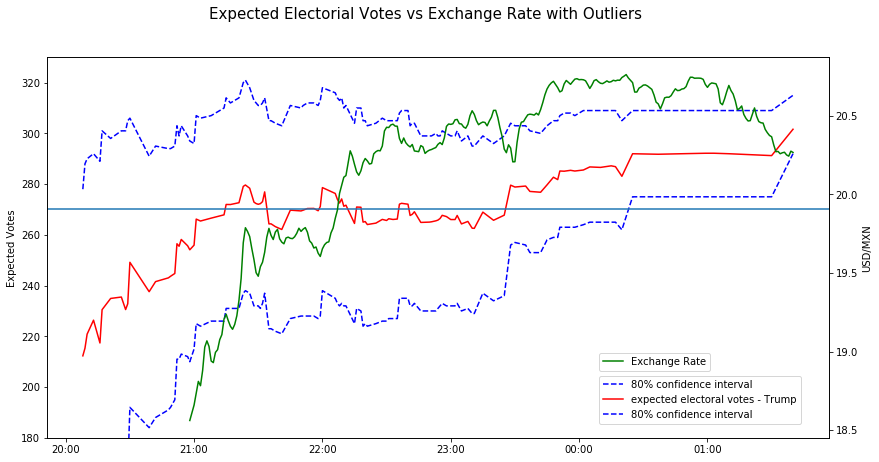

In [298]:
#%%
fig, ax1 = plt.subplots()
fig.set_size_inches(14, 7)
ax1.plot_date(pred.time, pred.low,'b--', label='80% confidence interval')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes - Trump')
#ax1.plot_date(pred.time, pred.clinton,'c-', label='expected electoral votes - Clinton')
ax1.plot_date(pred.time, pred.high,'b--', label='80% confidence interval')
plt.ylabel('Expected Votes')
#pylab.legend(loc='lower right')
plt.axhline(y=270)
ax1.legend(loc='center left', bbox_to_anchor=(0.7, 0.1))
ax1.set_ylim([180,330])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('USD/MXN')

#pylab.legend(loc='upper right')
ax2.legend(loc='center left', bbox_to_anchor=(0.7, 0.2))

fig.suptitle('Expected Electorial Votes vs Exchange Rate with Outliers', fontsize=15)

#plt.figure(figsize=(20,10))
plt.show()
fig.savefig('results.png')

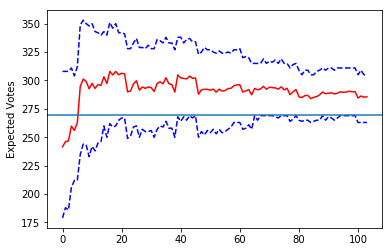

In [163]:
#plot after each update
fig, ax1 = plt.subplots()
ax1.plot(pred.low,'b--', label='80% confidence')
ax1.plot(pred.ave,'r-', label='expected electoral votes')
ax1.plot(pred.high,'b--', label='80% confidence')
plt.ylabel('Expected Votes')
plt.axhline(y=270)
plt.show()

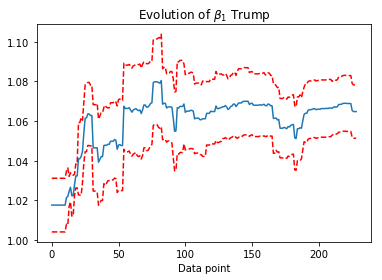

In [294]:
plt.plot(parameters_trump[50:len(jointb)-20,1])
plt.plot(parameters_trump[50:len(jointb)-20,1]-stderr_trump[50:len(jointb)-20,1],'r--')
plt.plot(parameters_trump[50:len(jointb)-20,1]+stderr_trump[50:len(jointb)-20,1],'r--')
plt.title(r'Evolution of $\beta_1 $ Trump')
plt.xlabel('Data point')
plt.savefig('trump b1.png')
plt.show()

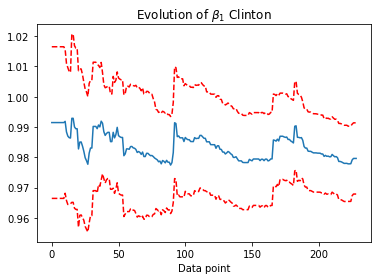

In [296]:
plt.plot(parameters_clinton[50:len(jointb)-20,0])
plt.plot(parameters_clinton[50:len(jointb)-20,1]-stderr_clinton[50:len(jointb)-20,1],'r--')
plt.plot(parameters_clinton[50:len(jointb)-20,1]+stderr_clinton[50:len(jointb)-20,1],'r--')
#plt.axhline(y=1)
plt.title(r'Evolution of $\beta_1 $ Clinton')
plt.xlabel('Data point')
plt.savefig('clinton b1.png')
plt.show()

In [257]:
    i=141
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')
    #intermediate = intermediate[intermediate.rprpc>20]
    intermediate = intermediate[intermediate.State!='new york']
    intermediate = intermediate[intermediate.State!='montana']
    intermediate = intermediate[intermediate.State!='utah']
    intermediate = intermediate[intermediate.State!='texas']
    intermediate = intermediate[np.bitwise_and(intermediate.State!='georgia' , intermediate.rprpc!=7)]
    
    if not intermediate[intermediate.State=='iowa'].empty and (intermediate[intermediate.State=='iowa']['rprpc']<50).bool():
        intermediate = intermediate[intermediate.State!='iowa']

    X_dt=intermediate['poll_dt']
    Y_dt=intermediate['trump']
    #X_dt=sm.add_constant(X_dt)
    model_dt = sm.WLS(Y_dt.values, X_dt.values,weights=intermediate['rprpc']).fit()
    
    #extract parameters
    params_dt = np.random.multivariate_normal(model_dt.params, RegressionResults.cov_params(model_dt), sim_num)
#    slope_dt = np.random.normal(model_dt.params[1], model_dt.bse[1], sim_num)
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    #X_hc=sm.add_constant(X_hc)
    model_hc = sm.WLS(Y_hc.values, X_hc.values,weights=intermediate['rprpc']).fit()
    
    #extract parameters
    params_hc = np.random.multivariate_normal(model_hc.params, RegressionResults.cov_params(model_hc), sim_num)
#    slope_hc = np.random.normal(model_hc.params[1], model_hc.bse[1], sim_num)
    
    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')
    
    result = np.zeros([sim_num, len(remain)])
    
    result_dt = np.dot(params_dt,np.matrix(remain['poll_dt']))
    #result_dt = np.random.normal(result_dt, np.std(model_dt.resid))
    err_dev = np.std(model_dt.resid)*(np.random.chisquare(len(model_dt.resid)-2)*1./(len(model_dt.resid)-2))**0.5
    result_dt = np.random.normal(result_dt, err_dev)
        
        
        #clinton
    #result_hc = np.dot(params_hc, sm.add_constant(np.array(remain['poll_hc'])).T) 
    result_hc = np.dot(params_hc, np.matrix(remain['poll_hc'])) 
    #result_hc = np.random.normal(result_hc, np.std(model_hc.resid))
    err_dev = np.std(model_hc.resid)*(np.random.chisquare(len(model_hc.resid)-2)*1./(len(model_hc.resid)-2))**0.5
    result_hc =  np.random.normal(result_hc, err_dev)
        
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
    
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>=select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=sum(full_result['result'] * full_result['EV'])+ np.dot(result, remain['EV'])
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot

    pred.time[i]=jointb.time[i]
    pred.state[i]=jointb.State[i]
    pred.low[i]=np.percentile(EEV,10)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.percentile(EEV,90)
    print(pred.time[i])
    print(model_dt.summary())

AttributeError: module 'numpy.random' has no attribute 'randrange'

In [98]:
np.mean(EEV)

294.66899999999998

In [99]:
intermediate

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
92,texas,42.5,51.0,4.9,NaN,2016-11-08 21:35:00,50.6,45.5,38,1,65.0
120,virginia,49.8,44.3,4.7,NaN,2016-11-08 22:00:00,47.2,47.7,13,1,83.0
122,florida,48.1,47.5,3.2,NaN,2016-11-08 22:00:00,49.2,47.7,29,1,95.0
123,new hampshire,47.5,43.9,7.3,NaN,2016-11-08 22:00:00,48.3,46.5,4,1,41.0
127,pennsylvania,48.9,45.2,4.6,NaN,2016-11-08 22:00:00,42.2,54.6,20,1,34.0
133,michigan,48.4,44.2,6.1,NaN,2016-11-08 22:07:00,49.7,45.1,16,1,25.0
135,wisconsin,49.6,44.3,4.9,NaN,2016-11-08 22:08:00,49.9,45.0,10,1,32.0
136,north carolina,48.2,47.5,4.3,NaN,2016-11-08 22:08:00,50.4,47.0,15,1,83.0
137,georgia,45.5,49.5,5.0,NaN,2016-11-08 22:09:00,56.8,40.4,16,1,46.0
138,ohio,45.8,47.7,5.3,NaN,2016-11-08 22:10:00,53.4,42.2,18,1,72.0


In [96]:
model_hc.summary()

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.130
Model:                            WLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.643
Date:                Thu, 25 Jan 2018   Prob (F-statistic):              0.226
Time:                        19:45:52   Log-Likelihood:                -32.544
No. Observations:                  13   AIC:                             69.09
Df Residuals:                      11   BIC:                             70.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.0971     20.018      1.054      0.315     -22.962      65.157
x1             0.5441      0.424      1.282      0.226      -0.390       1.478
==============================================================================
Omnibus:                        0.080   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.152
Skew:                           0.121   Prob(JB):                        0.927
Kurtosis:                       2.528   Cond. No.                     1.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
model_hc.summary()

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.220
Model:                            WLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     2.814
Date:                Thu, 25 Jan 2018   Prob (F-statistic):              0.124
Time:                        19:46:25   Log-Likelihood:                -29.072
No. Observations:                  12   AIC:                             62.14
Df Residuals:                      10   BIC:                             63.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5747     19.007      0.767      0.461     -27.776      56.926
x1             0.6745      0.402      1.678      0.124      -0.221       1.570
==============================================================================
Omnibus:                        0.254   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.146
Skew:                           0.198   Prob(JB):                        0.929
Kurtosis:                       2.631   Cond. No.                     1.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [278]:

#storing result
columns = ['time', 'state','low', 'ave', 'high']
index= jointb.index
pred=pd.DataFrame(index=index, columns=columns)

#number of simulation for (a,b) and (error)
sim_num = 10


for i in range(50,len(jointb)-4):
    
    #Trump regression
    #fit linear regression
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')
    #intermediate = intermediate[intermediate.rprpc>20]
    intermediate = intermediate[intermediate.State!='new york']
    intermediate = intermediate[intermediate.State!='montana']
    intermediate = intermediate[intermediate.State!='utah']
    intermediate = intermediate[intermediate.State!='texas']
    intermediate = intermediate[np.bitwise_and(intermediate.State!='georgia' , intermediate.rprpc!=7)]
    
    if not intermediate[intermediate.State=='iowa'].empty and (intermediate[intermediate.State=='iowa']['rprpc']<50).bool():
        intermediate = intermediate[intermediate.State!='iowa']

    X_dt=intermediate['poll_dt']
    if len(X_dt)<4:
        continue
    Y_dt=intermediate['trump']
    #X_dt=sm.add_constant(X_dt)
    model_dt = sm.WLS(Y_dt.values, X_dt.values,weights=intermediate['rprpc']).fit()
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    #X_hc=sm.add_constant(X_hc)
    model_hc = sm.WLS(Y_hc.values, X_hc.values,weights=intermediate['rprpc']).fit()
    
    
    prob = np.zeros(100)
    for k in range(0,100):
    #extract parameters
        params_dt = np.random.multivariate_normal(model_dt.params, RegressionResults.cov_params(model_dt), sim_num)
    #    slope_dt = np.random.normal(model_dt.params[1], model_dt.bse[1], sim_num)



        #extract parameters
        params_hc = np.random.multivariate_normal(model_hc.params, RegressionResults.cov_params(model_hc), sim_num)
    #    slope_hc = np.random.normal(model_hc.params[1], model_hc.bse[1], sim_num)

        #make predictions, use states with no results and intermediate results
        remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')

        result = np.zeros([sim_num, len(remain)])
    

        
        for j in range(0, sim_num):

            #trump
            #result_dt = np.dot(params_dt,sm.add_constant(np.array(remain['poll_dt'])).T)
            result_dt = np.dot(params_dt,np.matrix(remain['poll_dt']))
            err_dev = np.std(model_dt.resid)*(np.random.chisquare(len(model_dt.resid)-2)*1./(len(model_dt.resid)-2))**0.5
            result_dt = np.random.normal(result_dt, err_dev)


            #clinton
            #result_hc = np.dot(params_hc, sm.add_constant(np.array(remain['poll_hc'])).T) 
            result_hc = np.dot(params_hc, np.matrix(remain['poll_hc'])) 
            err_dev = np.std(model_hc.resid)*(np.random.chisquare(len(model_hc.resid)-2)*1./(len(model_hc.resid)-2))**0.5
            result_hc =  np.random.normal(result_hc, err_dev)

            result_temp = result_dt>result_hc
            result = np.append(result, result_temp,axis=0)
       
        #remove the zeros during initialisation
        result = np.delete(result,range(0,sim_num),0)
        result = result.astype(int)

        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>=select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
        EEV=sum(full_result['result'] * full_result['EV'])+ np.dot(result, remain['EV'])
        
        prob[k] = sum(EEV>270)/len(EEV)
    

    #make table for plot

    pred.time[i]=jointb.time[i]
    pred.state[i]=jointb.State[i]
    pred.low[i]=np.percentile(prob,10)
    pred.ave[i]=np.mean(prob)
    pred.high[i]=np.percentile(prob,90)
    print(pred.time[i])
    print(model_dt.summary())

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

2016-11-08 20:58:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2428.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.50e-08
Time:                        16:43:13   Log-Likelihood:                -14.238
No. Observations:                   6   AIC:                             30.48
Df Residuals:                       5   BIC:                             30.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0418      0.021

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


2016-11-08 21:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2428.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.50e-08
Time:                        16:43:14   Log-Likelihood:                -14.238
No. Observations:                   6   AIC:                             30.48
Df Residuals:                       5   BIC:                             30.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0418      0.021

2016-11-08 21:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2428.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.50e-08
Time:                        16:43:16   Log-Likelihood:                -14.238
No. Observations:                   6   AIC:                             30.48
Df Residuals:                       5   BIC:                             30.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0418      0.021

2016-11-08 21:01:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3116.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.49e-08
Time:                        16:43:19   Log-Likelihood:                -13.527
No. Observations:                   6   AIC:                             29.05
Df Residuals:                       5   BIC:                             28.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0445      0.019

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


2016-11-08 21:03:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1731.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.29e-08
Time:                        16:43:21   Log-Likelihood:                -18.812
No. Observations:                   7   AIC:                             39.62
Df Residuals:                       6   BIC:                             39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0403      0.025

2016-11-08 21:15:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2164.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.61e-09
Time:                        16:43:24   Log-Likelihood:                -18.041
No. Observations:                   7   AIC:                             38.08
Df Residuals:                       6   BIC:                             38.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0491      0.023

2016-11-08 21:24:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2310.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           5.44e-09
Time:                        16:43:26   Log-Likelihood:                -17.659
No. Observations:                   7   AIC:                             37.32
Df Residuals:                       6   BIC:                             37.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0565      0.022

2016-11-08 21:28:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2490.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.40e-10
Time:                        16:43:29   Log-Likelihood:                -19.842
No. Observations:                   8   AIC:                             41.68
Df Residuals:                       7   BIC:                             41.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0460      0.021

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


2016-11-08 21:29:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2490.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.40e-10
Time:                        16:43:29   Log-Likelihood:                -19.842
No. Observations:                   8   AIC:                             41.68
Df Residuals:                       7   BIC:                             41.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0460      0.021

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


2016-11-08 21:31:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2803.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.80e-11
Time:                        16:43:31   Log-Likelihood:                -22.519
No. Observations:                   9   AIC:                             47.04
Df Residuals:                       8   BIC:                             47.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0463      0.020

2016-11-08 21:35:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4546.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.60e-12
Time:                        16:43:33   Log-Likelihood:                -20.229
No. Observations:                   9   AIC:                             42.46
Df Residuals:                       8   BIC:                             42.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0508      0.016

2016-11-08 21:36:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3338.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           8.94e-12
Time:                        16:43:36   Log-Likelihood:                -21.496
No. Observations:                   9   AIC:                             44.99
Df Residuals:                       8   BIC:                             45.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0488      0.018

2016-11-08 21:45:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2931.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.50e-11
Time:                        16:43:38   Log-Likelihood:                -22.114
No. Observations:                   9   AIC:                             46.23
Df Residuals:                       8   BIC:                             46.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0506      0.019

2016-11-08 21:45:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2656.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.23e-11
Time:                        16:43:41   Log-Likelihood:                -22.350
No. Observations:                   9   AIC:                             46.70
Df Residuals:                       8   BIC:                             46.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0534      0.020

2016-11-08 21:50:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2628.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.32e-11
Time:                        16:43:43   Log-Likelihood:                -22.297
No. Observations:                   9   AIC:                             46.59
Df Residuals:                       8   BIC:                             46.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0529      0.021

2016-11-08 21:58:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2438.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.13e-11
Time:                        16:43:46   Log-Likelihood:                -22.557
No. Observations:                   9   AIC:                             47.11
Df Residuals:                       8   BIC:                             47.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0550      0.021

2016-11-08 22:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2635.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.30e-11
Time:                        16:43:48   Log-Likelihood:                -22.338
No. Observations:                   9   AIC:                             46.68
Df Residuals:                       8   BIC:                             46.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0548      0.021

2016-11-08 22:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2991.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.15e-12
Time:                        16:43:50   Log-Likelihood:                -25.810
No. Observations:                  10   AIC:                             53.62
Df Residuals:                       9   BIC:                             53.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0572      0.019

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


2016-11-08 22:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3223.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           8.22e-13
Time:                        16:43:51   Log-Likelihood:                -25.555
No. Observations:                  10   AIC:                             53.11
Df Residuals:                       9   BIC:                             53.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0576      0.019

2016-11-08 22:07:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3942.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.33e-13
Time:                        16:43:53   Log-Likelihood:                -24.254
No. Observations:                  10   AIC:                             50.51
Df Residuals:                       9   BIC:                             50.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0601      0.017

2016-11-08 22:09:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4531.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.78e-13
Time:                        16:43:56   Log-Likelihood:                -22.437
No. Observations:                  10   AIC:                             46.87
Df Residuals:                       9   BIC:                             47.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0602      0.016

2016-11-08 22:15:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4180.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.91e-14
Time:                        16:43:58   Log-Likelihood:                -25.420
No. Observations:                  11   AIC:                             52.84
Df Residuals:                      10   BIC:                             53.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0517      0.016

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


2016-11-08 22:16:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4173.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.92e-14
Time:                        16:43:59   Log-Likelihood:                -25.433
No. Observations:                  11   AIC:                             52.87
Df Residuals:                      10   BIC:                             53.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0520      0.016

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


2016-11-08 22:18:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3446.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           4.33e-15
Time:                        16:44:00   Log-Likelihood:                -29.765
No. Observations:                  12   AIC:                             61.53
Df Residuals:                      11   BIC:                             62.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0578      0.018

2016-11-08 22:20:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4074.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.73e-15
Time:                        16:44:02   Log-Likelihood:                -28.677
No. Observations:                  12   AIC:                             59.35
Df Residuals:                      11   BIC:                             59.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0581      0.017

2016-11-08 22:28:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4010.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.89e-15
Time:                        16:44:05   Log-Likelihood:                -28.742
No. Observations:                  12   AIC:                             59.48
Df Residuals:                      11   BIC:                             59.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0595      0.017

2016-11-08 22:31:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4215.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.43e-15
Time:                        16:44:07   Log-Likelihood:                -28.426
No. Observations:                  12   AIC:                             58.85
Df Residuals:                      11   BIC:                             59.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0586      0.016

2016-11-08 22:31:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4290.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.30e-15
Time:                        16:44:09   Log-Likelihood:                -28.316
No. Observations:                  12   AIC:                             58.63
Df Residuals:                      11   BIC:                             59.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0580      0.016

2016-11-08 22:36:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4678.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           8.11e-16
Time:                        16:44:12   Log-Likelihood:                -27.785
No. Observations:                  12   AIC:                             57.57
Df Residuals:                      11   BIC:                             58.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0599      0.015

2016-11-08 22:41:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4655.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           8.33e-16
Time:                        16:44:14   Log-Likelihood:                -27.780
No. Observations:                  12   AIC:                             57.56
Df Residuals:                      11   BIC:                             58.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0603      0.016

2016-11-08 22:46:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4921.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.13e-16
Time:                        16:44:17   Log-Likelihood:                -27.471
No. Observations:                  12   AIC:                             56.94
Df Residuals:                      11   BIC:                             57.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0624      0.015

2016-11-08 22:53:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5098.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           5.05e-16
Time:                        16:44:19   Log-Likelihood:                -27.247
No. Observations:                  12   AIC:                             56.49
Df Residuals:                      11   BIC:                             56.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0630      0.015

2016-11-08 22:56:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5183.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           4.62e-16
Time:                        16:44:21   Log-Likelihood:                -27.123
No. Observations:                  12   AIC:                             56.25
Df Residuals:                      11   BIC:                             56.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0652      0.015

2016-11-08 23:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5282.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           4.16e-16
Time:                        16:44:24   Log-Likelihood:                -27.015
No. Observations:                  12   AIC:                             56.03
Df Residuals:                      11   BIC:                             56.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0658      0.015

2016-11-08 23:03:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5550.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.17e-16
Time:                        16:44:26   Log-Likelihood:                -26.713
No. Observations:                  12   AIC:                             55.43
Df Residuals:                      11   BIC:                             55.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0654      0.014

2016-11-08 23:05:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5631.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.93e-16
Time:                        16:44:29   Log-Likelihood:                -26.616
No. Observations:                  12   AIC:                             55.23
Df Residuals:                      11   BIC:                             55.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0649      0.014

2016-11-08 23:10:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5675.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.81e-16
Time:                        16:44:31   Log-Likelihood:                -26.570
No. Observations:                  12   AIC:                             55.14
Df Residuals:                      11   BIC:                             55.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0650      0.014

2016-11-08 23:15:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5683.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.78e-16
Time:                        16:44:33   Log-Likelihood:                -26.561
No. Observations:                  12   AIC:                             55.12
Df Residuals:                      11   BIC:                             55.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0646      0.014

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


2016-11-08 23:20:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4949.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           4.53e-17
Time:                        16:44:34   Log-Likelihood:                -30.034
No. Observations:                  13   AIC:                             62.07
Df Residuals:                      12   BIC:                             62.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0576      0.015

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


2016-11-08 23:28:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     5485.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.85e-18
Time:                        16:44:37   Log-Likelihood:                -32.149
No. Observations:                  14   AIC:                             66.30
Df Residuals:                      13   BIC:                             66.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0552      0.014

2016-11-08 23:35:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5649.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.52e-18
Time:                        16:44:39   Log-Likelihood:                -31.945
No. Observations:                  14   AIC:                             65.89
Df Residuals:                      13   BIC:                             66.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0560      0.014

2016-11-08 23:37:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4940.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           3.02e-19
Time:                        16:44:42   Log-Likelihood:                -35.724
No. Observations:                  15   AIC:                             73.45
Df Residuals:                      14   BIC:                             74.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0508      0.015

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


2016-11-08 23:42:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4992.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.81e-19
Time:                        16:44:42   Log-Likelihood:                -35.642
No. Observations:                  15   AIC:                             73.28
Df Residuals:                      14   BIC:                             73.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0506      0.015

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


2016-11-08 23:45:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     5332.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.47e-20
Time:                        16:44:43   Log-Likelihood:                -38.028
No. Observations:                  16   AIC:                             78.06
Df Residuals:                      15   BIC:                             78.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0527      0.014

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


2016-11-08 23:48:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6610.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.81e-23
Time:                        16:44:44   Log-Likelihood:                -42.163
No. Observations:                  18   AIC:                             86.33
Df Residuals:                      17   BIC:                             87.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0565      0.013

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


2016-11-08 23:48:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6823.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.39e-23
Time:                        16:44:45   Log-Likelihood:                -41.911
No. Observations:                  18   AIC:                             85.82
Df Residuals:                      17   BIC:                             86.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0585      0.013

2016-11-08 23:48:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6769.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.48e-23
Time:                        16:44:47   Log-Likelihood:                -42.022
No. Observations:                  18   AIC:                             86.04
Df Residuals:                      17   BIC:                             86.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0603      0.013

2016-11-08 23:56:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6857.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.33e-23
Time:                        16:44:50   Log-Likelihood:                -41.900
No. Observations:                  18   AIC:                             85.80
Df Residuals:                      17   BIC:                             86.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0605      0.013

2016-11-08 23:56:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7273.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           8.07e-24
Time:                        16:44:52   Log-Likelihood:                -41.390
No. Observations:                  18   AIC:                             84.78
Df Residuals:                      17   BIC:                             85.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0614      0.012

2016-11-09 00:05:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7287.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           7.93e-24
Time:                        16:44:54   Log-Likelihood:                -41.370
No. Observations:                  18   AIC:                             84.74
Df Residuals:                      17   BIC:                             85.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0618      0.012

2016-11-09 00:15:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7539.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           5.95e-24
Time:                        16:44:57   Log-Likelihood:                -41.071
No. Observations:                  18   AIC:                             84.14
Df Residuals:                      17   BIC:                             85.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0623      0.012

2016-11-09 00:17:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7424.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.77e-24
Time:                        16:44:59   Log-Likelihood:                -41.256
No. Observations:                  18   AIC:                             84.51
Df Residuals:                      17   BIC:                             85.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0644      0.012

2016-11-09 00:17:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7567.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           5.76e-24
Time:                        16:45:01   Log-Likelihood:                -41.081
No. Observations:                  18   AIC:                             84.16
Df Residuals:                      17   BIC:                             85.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0642      0.012

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


2016-11-09 00:20:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7946.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.86e-25
Time:                        16:45:02   Log-Likelihood:                -43.296
No. Observations:                  19   AIC:                             88.59
Df Residuals:                      18   BIC:                             89.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0609      0.012

2016-11-09 00:37:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8141.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           2.30e-25
Time:                        16:45:05   Log-Likelihood:                -43.055
No. Observations:                  19   AIC:                             88.11
Df Residuals:                      18   BIC:                             89.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0603      0.012

2016-11-09 00:50:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8436.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.67e-25
Time:                        16:45:07   Log-Likelihood:                -42.733
No. Observations:                  19   AIC:                             87.47
Df Residuals:                      18   BIC:                             88.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0614      0.012

2016-11-09 01:10:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8501.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.56e-25
Time:                        16:45:09   Log-Likelihood:                -42.668
No. Observations:                  19   AIC:                             87.34
Df Residuals:                      18   BIC:                             88.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0617      0.012

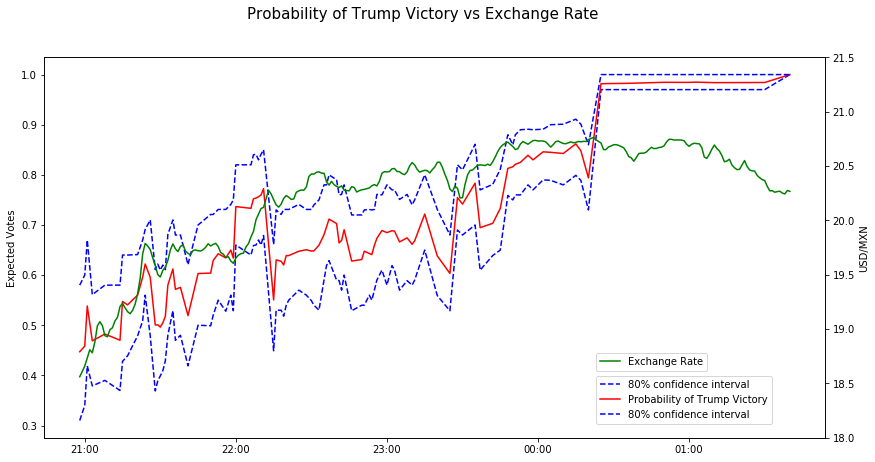

In [282]:

#%%
fig, ax1 = plt.subplots()
fig.set_size_inches(14, 7)
ax1.plot_date(pred.time, pred.low,'b--', label='80% confidence interval')
ax1.plot_date(pred.time, pred.ave,'r-', label='Probability of Trump Victory')
ax1.plot_date(pred.time, pred.high,'b--', label='80% confidence interval')
plt.ylabel('Expected Votes')
#pylab.legend(loc='lower right')
#plt.axhline(y=270)
ax1.legend(loc='center left', bbox_to_anchor=(0.7, 0.1))
#ax1.set_ylim([0.5,0.9])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')
ax2.set_ylim([18,21.5])

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('USD/MXN')

#pylab.legend(loc='upper right')
ax2.legend(loc='center left', bbox_to_anchor=(0.7, 0.2))

fig.suptitle('Probability of Trump Victory vs Exchange Rate', fontsize=15)

#plt.figure(figsize=(20,10))
plt.show()
fig.savefig('prob.png')

In [23]:
prob

array([  100.,   190.,   277.,   366.,   455.,   543.,   633.,   721.,
         811.,   899.,   988.,  1078.,  1168.,  1258.,  1347.,  1437.,
        1527.,  1617.,  1707.,  1796.,  1886.,  1975.,  2062.,  2152.,
        2242.,  2332.,  2423.,  2510.,  2600.,  2691.,  2782.,  2872.,
        2962.,  3052.,  3141.,  3230.,  3317.,  3407.,  3496.,  3584.,
        3675.,  3764.,  3854.,  3943.,  4033.,  4122.,  4212.,  4300.,
        4390.,  4480.,  4569.,  4658.,  4747.,  4836.,  4926.,  5016.,
        5106.,  5196.,  5285.,  5375.,  5464.,  5552.,  5641.,  5731.,
        5820.,  5909.,  5998.,  6088.,  6177.,  6266.,  6355.,  6445.,
        6532.,  6622.,  6711.,  6801.,  6891.,  6981.,  7070.,  7158.,
        7248.,  7337.,  7427.,  7517.,  7607.,  7697.,  7787.,  7877.,
        7967.,  8057.,  8145.,  8235.,  8325.,  8414.,  8503.,  8590.,
        8678.,  8767.,  8856.,  8946.])

In [33]:
np.sum((EEV>270))

5463

In [34]:
len(EEV)

7390

In [104]:
np.mean(params_hc, axis=0)

array([-2.38466829,  1.03097679])

In [106]:
model_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            WLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     36.05
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           1.12e-05
Time:                        15:35:01   Log-Likelihood:                -45.175
No. Observations:                  20   AIC:                             94.35
Df Residuals:                      18   BIC:                             96.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8070      8.037     -0.225      0.825     -18.692      15.078
x1             1.0171      0.169      6.004      0.000       0.661       1.373
==============================================================================
Omnibus:                        0.568   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.465
Skew:                           0.332   Prob(JB):                        0.793
Kurtosis:                       2.658   Cond. No.                         718.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
model_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8044.
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           1.97e-26
Time:                        15:55:11   Log-Likelihood:                -45.203
No. Observations:                  20   AIC:                             92.41
Df Residuals:                      19   BIC:                             93.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9791      0.011     89.686      0.000       0.956       1.002
==============================================================================
Omnibus:                        0.552   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.462
Skew:                           0.328   Prob(JB):                        0.794
Kurtosis:                       2.649   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
np.mean(params_hc,axis=0)

array([ 0.97731691])

In [130]:
remain

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
292,maine,49.5,42.0,7.0,0.0,2016-11-09 01:56:00,45.2,47.9,4,0,NaN
293,wisconsin,49.6,44.3,4.9,1.0,2016-11-09 02:29:00,47.9,46.9,10,0,NaN
294,minnesota,48.9,43.1,6.7,0.0,2016-11-09 11:09:00,45.4,46.9,10,0,NaN
295,alaska,40.9,48.3,9.2,1.0,2016-11-09 11:58:00,52.9,37.7,3,0,NaN
296,new hampshire,47.5,43.9,7.3,0.0,2016-11-09 12:00:00,47.2,47.6,4,0,NaN
297,arizona,45.4,47.6,5.6,1.0,2016-11-09 12:00:00,49.5,45.4,11,0,NaN
298,michigan,48.4,44.2,6.1,1.0,2016-11-09 12:00:00,47.6,47.3,16,0,NaN


In [182]:
    i=200
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')
    intermediate = intermediate[intermediate.rprpc>10]
    intermediate = intermediate[intermediate.State!='new york']
    intermediate = intermediate[intermediate.State!='montana']
    intermediate = intermediate[intermediate.State!='utah']
    intermediate = intermediate[intermediate.State!='texas']
    
    if not intermediate[intermediate.State=='iowa'].empty and (intermediate[intermediate.State=='iowa']['rprpc']<50).bool():
        intermediate = intermediate[intermediate.State!='iowa']

    X_dt=intermediate['poll_dt']
    Y_dt=intermediate['trump']
    #X_dt=sm.add_constant(X_dt)
    model_dt = sm.RLM(Y_dt.values, X_dt.values,weights=intermediate['rprpc']).fit()
    
    parameters_trump[i,:]=model_dt.params
    stderr_trump[i,:]=model_dt.bse
    
    #extract parameters
    params_dt = np.random.multivariate_normal(model_dt.params, RegressionResults.cov_params(model_dt), sim_num)
#    slope_dt = np.random.normal(model_dt.params[1], model_dt.bse[1], sim_num)
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    #X_hc=sm.add_constant(X_hc)
    model_hc = sm.WLS(Y_hc.values, X_hc.values,weights=intermediate['rprpc']).fit()
    
    parameters_clinton[i,:]=model_hc.params
    stderr_clinton[i,:]=model_hc.bse
    params_hc = np.random.multivariate_normal(model_hc.params, RegressionResults.cov_params(model_hc), sim_num)

    
    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')
    
    result = np.zeros([sim_num, len(remain)])
    
    for j in range(0, sim_num):
        
        #trump
        #result_dt = np.dot(params_dt,sm.add_constant(np.array(remain['poll_dt'])).T)
        result_dt = np.dot(params_dt,np.matrix(remain['poll_dt']))
        #result_dt = np.random.normal(result_dt, np.std(model_dt.resid))
        err_dev = np.std(model_dt.resid)*(np.random.chisquare(len(model_dt.resid)-2)*1./(len(model_dt.resid)-2))**0.5
        result_dt = np.random.normal(result_dt, err_dev)
        
        
        #clinton
        #result_hc = np.dot(params_hc, sm.add_constant(np.array(remain['poll_hc'])).T) 
        result_hc = np.dot(params_hc, np.matrix(remain['poll_hc'])) 
        #result_hc = np.random.normal(result_hc, np.std(model_hc.resid))
        err_dev = np.std(model_hc.resid)*(np.random.chisquare(len(model_hc.resid)-2)*1./(len(model_hc.resid)-2))**0.5
        result_hc =  np.random.normal(result_hc, err_dev)
        
        result_temp = result_dt>result_hc
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
    

In [183]:
intermediate

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
141,new mexico,45.7,39.9,13.1,NaN,2016-11-08 22:15:00,39.1,50.6,5,1,54.0
143,missouri,41.4,51.4,5.7,NaN,2016-11-08 22:16:00,63.0,32.5,10,1,18.0
155,ohio,45.8,47.7,5.3,NaN,2016-11-08 22:28:00,53.3,42.3,18,1,78.0
164,florida,48.1,47.5,3.2,NaN,2016-11-08 22:31:00,49.2,47.7,29,1,95.0
169,virginia,49.8,44.3,4.7,NaN,2016-11-08 22:35:00,46.6,48.2,13,1,88.0
182,colorado,47.7,43.6,7.5,NaN,2016-11-08 22:50:00,43.9,48.6,9,1,67.0
185,north carolina,48.2,47.5,4.3,NaN,2016-11-08 22:51:00,50.8,46.4,15,1,91.0
186,wisconsin,49.6,44.3,4.9,NaN,2016-11-08 22:53:00,49.0,45.9,10,1,56.0
187,michigan,48.4,44.2,6.1,NaN,2016-11-08 22:54:00,48.5,46.4,16,1,45.0
191,georgia,45.5,49.5,5.0,NaN,2016-11-08 22:56:00,56.8,40.5,16,1,49.0


In [251]:
full_result

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
0,kentucky,37.9,56.1,4.3,1.0,2016-11-08 18:59:00,62.5,32.7,8,0,NaN
1,indiana,40.4,52.0,7.6,1.0,2016-11-08 18:59:00,57.2,37.9,11,0,NaN
2,vermont,60.2,32.8,5.2,0.0,2016-11-08 18:59:00,32.6,61.1,3,0,NaN
3,west virginia,33.3,59.8,5.1,1.0,2016-11-08 19:30:00,68.7,26.5,5,0,NaN
8,massachusetts,58.0,34.6,5.8,0.0,2016-11-08 20:00:00,33.5,60.8,11,0,NaN
9,delaware,52.9,40.4,5.3,0.0,2016-11-08 20:00:00,41.9,53.4,3,0,NaN
10,oklahoma,33.2,59.2,7.6,1.0,2016-11-08 20:00:00,65.3,28.9,7,0,NaN
11,maryland,59.8,34.1,4.4,0.0,2016-11-08 20:00:00,35.3,60.5,10,0,NaN
12,new jersey,53.5,42.0,3.1,0.0,2016-11-08 20:00:00,41.8,55.0,14,0,NaN
13,district of columbia,82.9,12.4,1.8,0.0,2016-11-08 20:00:00,4.1,92.8,3,0,NaN


In [202]:
err_dev

3.0879314249870529

In [205]:
np.std(model_dt.resid)

2.9529983221451257